# Credit Card Default Prediction - Logistic Regression using XGBoost
#### Steps:
1. Load the data
2. Train a baseline model & evaluation
3. Hyperparameters tuning
4. Find optimal model & evaluation
<br>

#### Statistics of the optimal model:
1. **Accuracy score**: 0.834
2. **f1 score**: 0.475
3. **ROC AUC**: 0.659
4. **False Positive**: 184 cases, **False Negative**: 814 cases.
5. Top 3 important features: BILL_AMT1, LIMIT_BAL, BILL_AMT2; least 3 importance features: MARRIAGE, PAY_4, SEX.
<br>

#### Further research direction:
1. Decrease the amount of false negative cases.

In [2]:
!pip install xgboost

jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.10 which is incompatible.
You are using pip version 10.0.1, however version 20.3.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score
#from sklearn.model_selection import GridSearchCV

import time

## Load train & test data

In [6]:
# load pre-processed training set
path = '.\\' # change to your local file location

df_train = pd.read_csv(path + 'CreditCard_train_processed.csv')
df_test = pd.read_csv(path + 'CreditCard_test_processed.csv')

In [7]:
df_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,-1,-1,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,-1,-1,-1,-1,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,-1,-1,-1,-1,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,-1,-1,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,23996,80000,1,2,1,25,1,2,2,-1,...,80215,63296,49854,3800,6,3636,2646,2000,1830,0
23996,23997,20000,1,2,1,25,-1,-1,-1,-1,...,17322,17119,17350,1552,2659,1419,606,500,1000,0
23997,23998,10000,1,2,2,26,-1,-1,-1,-1,...,17506,16608,9176,1300,2200,1300,320,1820,1000,0
23998,23999,20000,1,4,2,26,-1,-1,-1,-1,...,39950,0,0,3055,1467,1096,1000,0,0,0


In [8]:
df_test

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,24001,50000,1,2,2,23,2,2,-1,-1,...,44116,21247,20066,8,2401,2254,2004,704,707,0
1,24002,60000,1,2,2,26,-1,-1,-1,-1,...,55736,26958,28847,2282,2324,2049,2000,3000,1120,1
2,24003,400000,1,2,2,27,-1,-1,-1,-1,...,10745,20737,9545,2501,10009,1437,1105,510,959,0
3,24004,20000,1,4,2,27,5,4,3,2,...,19709,20113,19840,0,0,0,900,0,0,0
4,24005,50000,1,3,2,27,-1,-1,-1,-1,...,0,70,120,0,100,0,70,200,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,29996,220000,1,3,1,39,-1,-1,-1,-1,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
5996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
5997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
5998,29999,80000,1,3,1,41,1,-1,-1,-1,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [10]:
# set up X and y variable matrices
Xtrain = df_train[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                   'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
Xtest = df_test[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

ytrain = df_train['default']
ytest = df_test['default']

## Model training

### Preparations: create DMatrix, write some helper functions

In [12]:
# create DMatrix
DTrain = xgb.DMatrix(Xtrain, label=ytrain)
DTest = xgb.DMatrix(Xtest, label=ytest)

In [231]:
# gridsearch parameter set (for 2 parameters) using 5-fold cross validation with single evaluation metrix 'error'
def gridsearch_best_params(params_set, param1_name:str, param2_name:str, string_format, figwidth=10):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['params', 'test-error-mean', 'boost rounds'])
    
    for param1, param2 in params_set:
        print(string_format.format(param1, param2))
        # update parameters
        params[param1_name] = param1
        params[param2_name] = param2
        
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=1000, # set up a large iteration, will stop early
            seed=42,
            nfold=5,
            metrics={'error'},
            early_stopping_rounds=15)
        
        # write down the results
        mean_error = cv_results['test-error-mean'].min()
        boost_rounds = cv_results['test-error-mean'].argmin()
        results = results.append({'params':"({},{})".format(param1, param2), 'test-error-mean':mean_error, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="params", y=["test-error-mean"], ax=ax[0], color='green')
    results.plot(x="params", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['params']) 
    fig.suptitle("Gridsearch CV for parameters tuning: {}, {}".format(param1_name, param2_name), fontsize=14)
    plt.show()
    
    print(results)

In [283]:
import time

# gridsearch parameter set (for single parameter) using 5-fold cross validation with single evaluation metrix 'error'
def gridsearch_best_param(param_set, param_name:str, string_format, figwidth=10, convert_to_str=False, timed=False):
    # create a DataFrame to hold the results
    results = pd.DataFrame(columns=['param', 'test-error-mean', 'boost rounds'])
    
    for param in param_set:
        print(string_format.format(param))
        # update parameters
        params[param_name] = param
        
        if timed:
            start = time.time()
        # run CV
        cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=1000,
            seed=42,
            nfold=5,
            metrics={'error'},
            early_stopping_rounds=15)
        
        if timed:
            end = time.time()
            print ("Time used:", end - start)
        
        # write down the results
        mean_error = cv_results['test-error-mean'].min()
        boost_rounds = cv_results['test-error-mean'].argmin()
        results = results.append({'param':param, 'test-error-mean':mean_error, 'boost rounds':boost_rounds},
                                ignore_index=True)
    
    # visualise the results
    if convert_to_str:
        results['param'] = results['param'].astype(str)
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(figwidth,8))
    results.plot(x="param", y=["test-error-mean"], ax=ax[0], color='green')
    results.plot(x="param", y=["boost rounds"], ax=ax[1], x_compat=True)

    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.xticks(results.index, results['param'])
    fig.suptitle("Gridsearch CV for parameter tuning: {}".format(param_name), fontsize=14)
    plt.show()
    
    print(results)

### Baseline model:  hyperparameters with default values

In [333]:
params = {
    # parameters for tree booster (to be tuned)
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    # other parameters
    'objective': 'binary:logistic',
    'eval_metric': 'logloss' # default for classification task
}

In [334]:
xgb0 = xgb.train(
    params,
    DTrain,
    num_boost_round=1000,
    evals=[(DTest, "Test")],
    early_stopping_rounds=20
)

print("Lowest logloss: {:.2f} with {} rounds".format(xgb0.best_score, xgb0.best_iteration+1))

[0]	Test-logloss:0.57115
Will train until Test-logloss hasn't improved in 20 rounds.
[1]	Test-logloss:0.50502
[2]	Test-logloss:0.46708
[3]	Test-logloss:0.44470
[4]	Test-logloss:0.43164
[5]	Test-logloss:0.42412
[6]	Test-logloss:0.41881
[7]	Test-logloss:0.41528
[8]	Test-logloss:0.41252
[9]	Test-logloss:0.41055
[10]	Test-logloss:0.40950
[11]	Test-logloss:0.40943
[12]	Test-logloss:0.40848
[13]	Test-logloss:0.40823
[14]	Test-logloss:0.40838
[15]	Test-logloss:0.40922
[16]	Test-logloss:0.40911
[17]	Test-logloss:0.40963
[18]	Test-logloss:0.41008
[19]	Test-logloss:0.40969
[20]	Test-logloss:0.40970
[21]	Test-logloss:0.40978
[22]	Test-logloss:0.41010
[23]	Test-logloss:0.41043
[24]	Test-logloss:0.41045
[25]	Test-logloss:0.41049
[26]	Test-logloss:0.41121
[27]	Test-logloss:0.41155
[28]	Test-logloss:0.41195
[29]	Test-logloss:0.41259
[30]	Test-logloss:0.41274
[31]	Test-logloss:0.41268
[32]	Test-logloss:0.41275
[33]	Test-logloss:0.41288
Stopping. Best iteration:
[13]	Test-logloss:0.40823

Lowest loglos

In [335]:
predictions = [int(round(value)) for value in xgb0.predict(DTest)]

In [336]:
# evaluation - scores
print('accuracy score:', accuracy_score(y_true = ytest, y_pred = predictions))
print('f1 score:', f1_score(y_true = ytest, y_pred = predictions))
print('ROC AUC:', roc_auc_score(y_true = ytest, y_score = predictions))

accuracy score: 0.8276666666666667
f1 score: 0.4653567735263703
ROC AUC: 0.6547001924166612


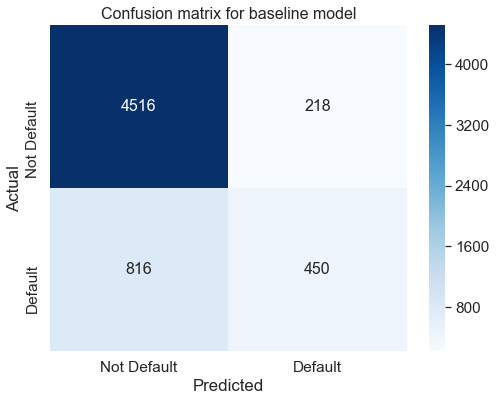

In [224]:
# evaluation - confusion matrix
xgb0_cm = pd.DataFrame(confusion_matrix(ytest, predictions), 
                       columns=['Not Default', 'Default'], index = ['Not Default', 'Default'])
xgb0_cm.index.name = 'Actual'
xgb0_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4) # label size
sns.heatmap(xgb0_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}) # integer format, font size 16
plt.title('Confusion matrix for baseline model', fontsize=16)
plt.show()

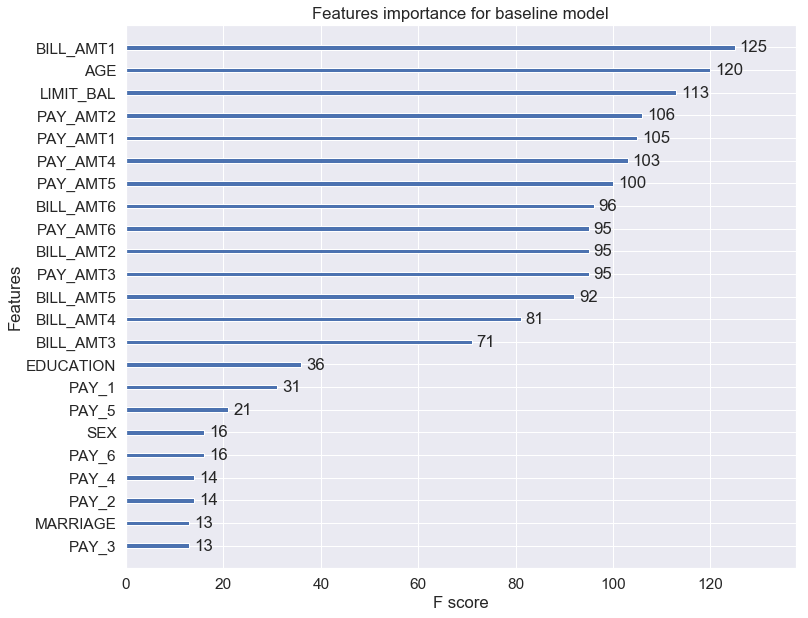

In [225]:
# features importance
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(xgb0, importance_type='weight', ax=ax)
plt.title('Features importance for baseline model')
plt.show()

Summary of the statistics of the baseline model:
1. **Accuracy score**: 0.828
2. **f1 score**: 0.465
3. **ROC AUC**: 0.655
4. **False Positive**: 218 cases, **False Negative**: 816 cases.
5. Top 3 important features: BILL_AMT1, AGE, LIMIT_BAL; least 3 importance features: PAY_3, MARRIAGE, PAY_2.

### Parameters Tuning

#### Step 1: Tune max_depth and min_child_weight
*background information...*

CV with max_depth=3, min_child_weight=1
CV with max_depth=3, min_child_weight=3
CV with max_depth=3, min_child_weight=5
CV with max_depth=5, min_child_weight=1
CV with max_depth=5, min_child_weight=3
CV with max_depth=5, min_child_weight=5
CV with max_depth=7, min_child_weight=1
CV with max_depth=7, min_child_weight=3
CV with max_depth=7, min_child_weight=5
CV with max_depth=9, min_child_weight=1
CV with max_depth=9, min_child_weight=3
CV with max_depth=9, min_child_weight=5


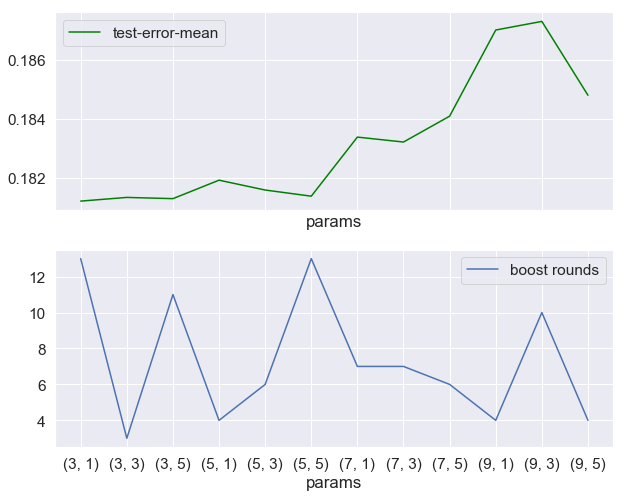

    params  test-error-mean boost rounds
0   (3, 1)         0.181208           13
1   (3, 3)         0.181333            3
2   (3, 5)         0.181292           11
3   (5, 1)         0.181917            4
4   (5, 3)         0.181584            6
5   (5, 5)         0.181375           13
6   (7, 1)         0.183375            7
7   (7, 3)         0.183208            7
8   (7, 5)         0.184083            6
9   (9, 1)         0.187000            4
10  (9, 3)         0.187292           10
11  (9, 5)         0.184792            4


In [196]:
# perform GridSearch on testing 12 combinations
param_test1 = [(max_depth, min_child_weight)
              for max_depth in range(3,10,2)
              for min_child_weight in range(1,6,2)]

gridsearch_best_params(param_test1, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}")

Choose (3,3) which has a good balance of low test-error-mean and low boost rounds.
<br>
Need to check optimal value in step 1.

CV with max_depth=2, min_child_weight=2
CV with max_depth=2, min_child_weight=3
CV with max_depth=2, min_child_weight=4
CV with max_depth=3, min_child_weight=2
CV with max_depth=3, min_child_weight=3
CV with max_depth=3, min_child_weight=4
CV with max_depth=4, min_child_weight=2
CV with max_depth=4, min_child_weight=3
CV with max_depth=4, min_child_weight=4


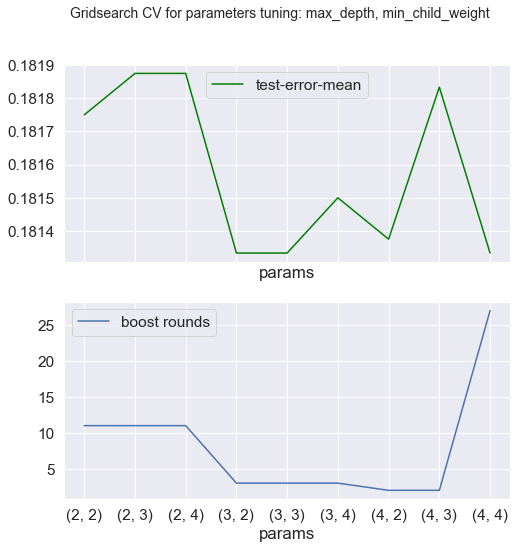

   params  test-error-mean boost rounds
0  (2, 2)         0.181750           11
1  (2, 3)         0.181875           11
2  (2, 4)         0.181875           11
3  (3, 2)         0.181333            3
4  (3, 3)         0.181333            3
5  (3, 4)         0.181500            3
6  (4, 2)         0.181375            2
7  (4, 3)         0.181833            2
8  (4, 4)         0.181333           27


In [203]:
# test values in step 1, centred at (3,3)
param_test1b = [(max_depth, min_child_weight)
              for max_depth in [2,3,4]
              for min_child_weight in [2,3,4]]

gridsearch_best_params(param_test1b, 'max_depth', 'min_child_weight', "CV with max_depth={}, min_child_weight={}", 8)

(3,3) is still the optimal one.

In [277]:
# update best parameters
params['max_depth'] = 3
params['min_child_weight'] = 3

#### Step 2: Tune subsamples and colsample_bytree
*background information...*

CV with subsample=0.7, colsample_bytree=0.7
CV with subsample=0.7, colsample_bytree=0.8
CV with subsample=0.7, colsample_bytree=0.9
CV with subsample=0.7, colsample_bytree=1.0
CV with subsample=0.8, colsample_bytree=0.7
CV with subsample=0.8, colsample_bytree=0.8
CV with subsample=0.8, colsample_bytree=0.9
CV with subsample=0.8, colsample_bytree=1.0
CV with subsample=0.9, colsample_bytree=0.7
CV with subsample=0.9, colsample_bytree=0.8
CV with subsample=0.9, colsample_bytree=0.9
CV with subsample=0.9, colsample_bytree=1.0
CV with subsample=1.0, colsample_bytree=0.7
CV with subsample=1.0, colsample_bytree=0.8
CV with subsample=1.0, colsample_bytree=0.9
CV with subsample=1.0, colsample_bytree=1.0


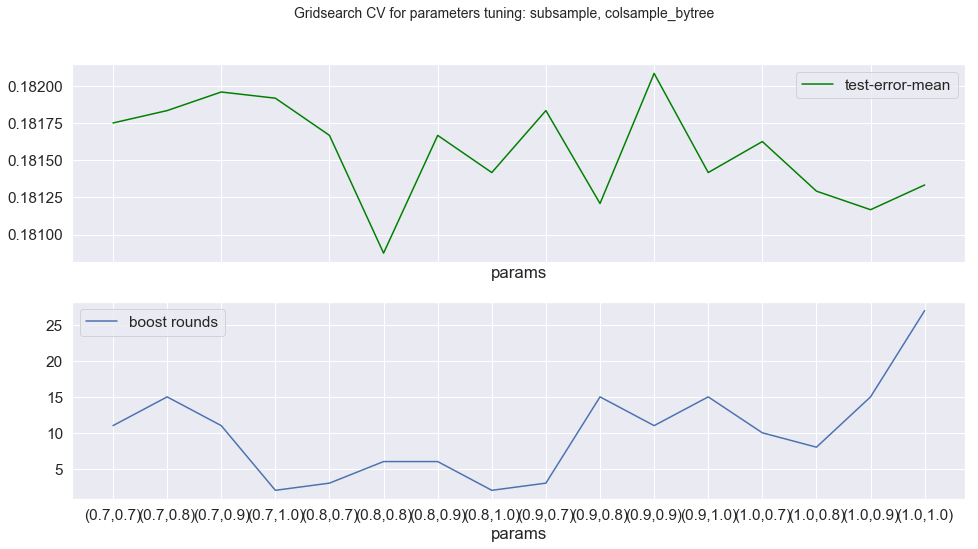

       params  test-error-mean boost rounds
0   (0.7,0.7)         0.181750           11
1   (0.7,0.8)         0.181833           15
2   (0.7,0.9)         0.181958           11
3   (0.7,1.0)         0.181917            2
4   (0.8,0.7)         0.181667            3
5   (0.8,0.8)         0.180875            6
6   (0.8,0.9)         0.181667            6
7   (0.8,1.0)         0.181417            2
8   (0.9,0.7)         0.181833            3
9   (0.9,0.8)         0.181208           15
10  (0.9,0.9)         0.182083           11
11  (0.9,1.0)         0.181417           15
12  (1.0,0.7)         0.181625           10
13  (1.0,0.8)         0.181292            8
14  (1.0,0.9)         0.181167           15
15  (1.0,1.0)         0.181333           27


In [207]:
# perform GridSearch on testing 16 combinations
param_test2 = [(subsample, colsample)
              for subsample in [i/10 for i in range(7,11)]
              for colsample in [i/10 for i in range(7,11)]]

gridsearch_best_params(param_test2, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 16)

(0.8,0.8) has the lowest test-error-mean and relatively low boost rounds. This can be considered as the optimal.
<br>
Need to check optimal value in step 0.05.

CV with subsample=0.75, colsample_bytree=0.75
CV with subsample=0.75, colsample_bytree=0.8
CV with subsample=0.75, colsample_bytree=0.85
CV with subsample=0.8, colsample_bytree=0.75
CV with subsample=0.8, colsample_bytree=0.8
CV with subsample=0.8, colsample_bytree=0.85
CV with subsample=0.85, colsample_bytree=0.75
CV with subsample=0.85, colsample_bytree=0.8
CV with subsample=0.85, colsample_bytree=0.85


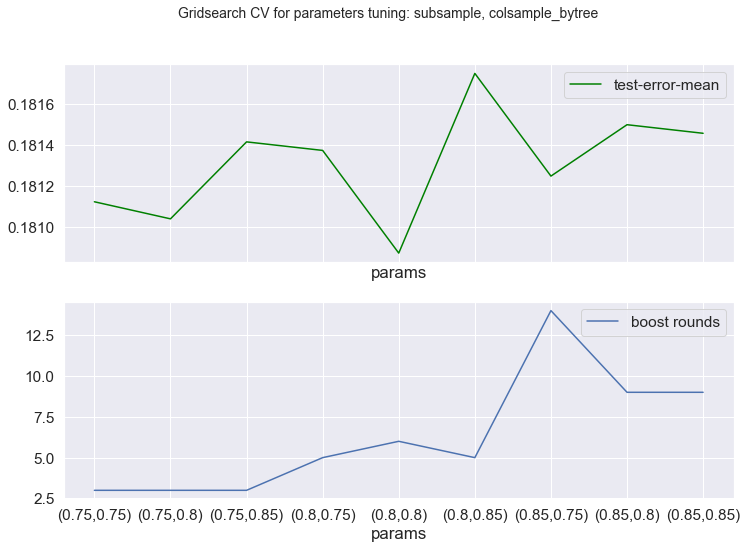

        params  test-error-mean boost rounds
0  (0.75,0.75)         0.181125            3
1   (0.75,0.8)         0.181042            3
2  (0.75,0.85)         0.181417            3
3   (0.8,0.75)         0.181375            5
4    (0.8,0.8)         0.180875            6
5   (0.8,0.85)         0.181750            5
6  (0.85,0.75)         0.181250           14
7   (0.85,0.8)         0.181500            9
8  (0.85,0.85)         0.181458            9


In [210]:
# test values in step 0.05, centred at (0.8,0.8)
param_test2b = [(subsample, colsample)
              for subsample in [i/100 for i in range(75,90,5)]
              for colsample in [i/100 for i in range(75,90,5)]]

gridsearch_best_params(param_test2b, 'subsample', 'colsample_bytree', "CV with subsample={}, colsample_bytree={}", 12)

(0.8,0.8) is still the optimal one.

In [278]:
# update best parameters
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

#### Step 3: Tune gamma
*background information...*

CV with gamma=0
CV with gamma=1
CV with gamma=2
CV with gamma=3
CV with gamma=4
CV with gamma=5
CV with gamma=6
CV with gamma=7
CV with gamma=8
CV with gamma=9
CV with gamma=10


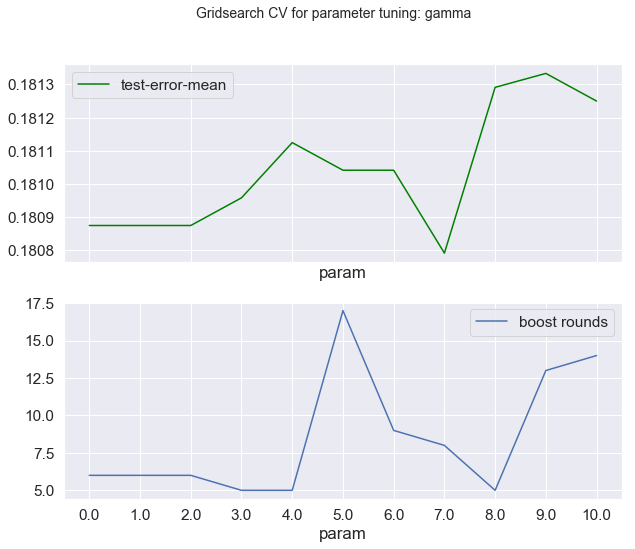

    param  test-error-mean  boost rounds
0     0.0         0.180875           6.0
1     1.0         0.180875           6.0
2     2.0         0.180875           6.0
3     3.0         0.180958           5.0
4     4.0         0.181125           5.0
5     5.0         0.181042          17.0
6     6.0         0.181042           9.0
7     7.0         0.180792           8.0
8     8.0         0.181291           5.0
9     9.0         0.181333          13.0
10   10.0         0.181250          14.0


In [218]:
# perform GridSearch on testing 11 values
param_test3 = [i for i in range(0,11)]

gridsearch_best_param(param_test3, 'gamma', "CV with gamma={}")

7.0 has the lowest test-error-mean and relatively low boost rounds. This can be considered as the optimal.

In [279]:
# update best parameter
params['gamma'] = 7

#### Step 4: Tune regularisation parameters - alpha, lambda
*background information...*

CV with alpha=1e-05
CV with alpha=0.01
CV with alpha=0.1
CV with alpha=1
CV with alpha=100


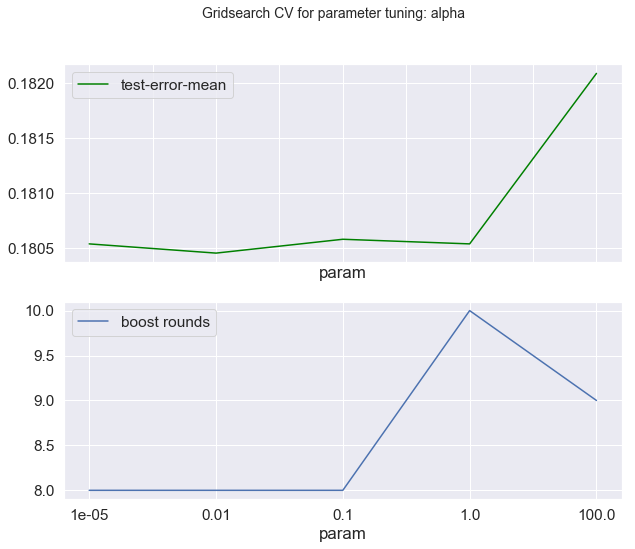

   param  test-error-mean  boost rounds
0  1e-05         0.180542           8.0
1   0.01         0.180458           8.0
2    0.1         0.180583           8.0
3    1.0         0.180542          10.0
4  100.0         0.182083           9.0


In [253]:
# perform GridSearch on testing 5 values for 'alpha'
param_test4_alpha = [1e-5, 1e-2, 0.1, 1, 100]

gridsearch_best_param(param_test4_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

alpha = 0.01 has the lowest test-error-mean and lowest boost rounds. Can be considered as the optimal value.
<br>
Try values closer to 0.01.

CV with alpha=0
CV with alpha=0.001
CV with alpha=0.005
CV with alpha=0.01
CV with alpha=0.05


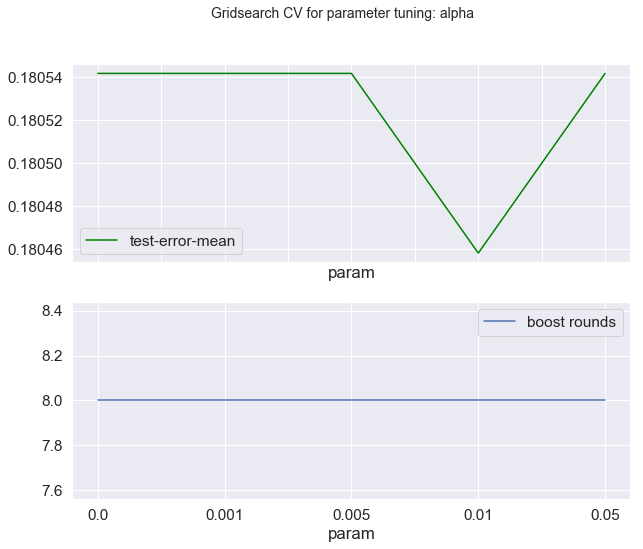

   param  test-error-mean  boost rounds
0    0.0         0.180542           8.0
1  0.001         0.180542           8.0
2  0.005         0.180542           8.0
3   0.01         0.180458           8.0
4   0.05         0.180542           8.0


In [254]:
# test values closer to 0.01
param_test4b_alpha = [0, 0.001, 0.005, 0.01, 0.05]

gridsearch_best_param(param_test4b_alpha, 'alpha', "CV with alpha={}", convert_to_str=True)

0.01 is still the optimal.

In [280]:
# update best parameter
params['alpha'] = 0.01

CV with lambda=1e-05
CV with lambda=0.01
CV with lambda=0.1
CV with lambda=1
CV with lambda=10
CV with lambda=50
CV with lambda=100


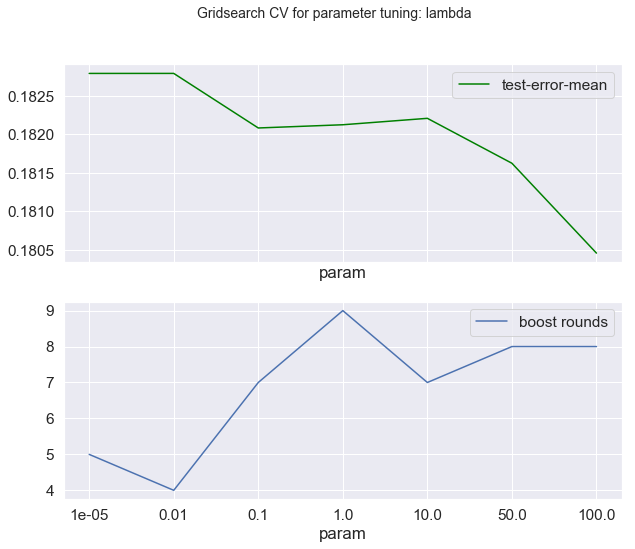

   param  test-error-mean  boost rounds
0  1e-05         0.182792           5.0
1   0.01         0.182792           4.0
2    0.1         0.182083           7.0
3    1.0         0.182125           9.0
4   10.0         0.182208           7.0
5   50.0         0.181625           8.0
6  100.0         0.180458           8.0


In [260]:
# perform GridSearch on testing 7 values for 'lambda'
param_test4_lambda = [1e-5, 1e-2, 0.1, 1, 10, 50, 100]

gridsearch_best_param(param_test4_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

The higher the lambda, the lower the test-error-mean. Take a closer look at the first slope: 0.01-0.1.

CV with lambda=0.001
CV with lambda=0.05
CV with lambda=0.01
CV with lambda=0.5
CV with lambda=1
CV with lambda=2.5
CV with lambda=5


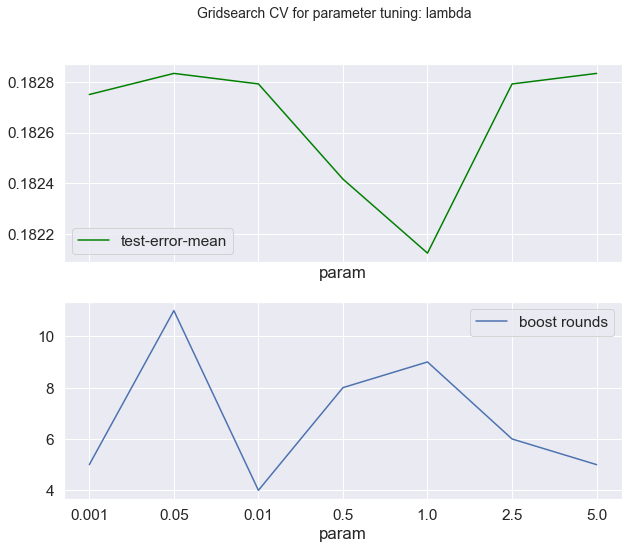

   param  test-error-mean  boost rounds
0  0.001         0.182750           5.0
1   0.05         0.182833          11.0
2   0.01         0.182792           4.0
3    0.5         0.182417           8.0
4    1.0         0.182125           9.0
5    2.5         0.182792           6.0
6    5.0         0.182833           5.0


In [261]:
# perform GridSearch on testing 7 values for 'lambda'
param_test4b_lambda = [0.001, 0.05, 0.01, 0.5, 1, 2.5, 5]

gridsearch_best_param(param_test4b_lambda, 'lambda', "CV with lambda={}", convert_to_str=True)

lambda = 1.0 has the lowest test-error-mean and lowest boost rounds. Can be considered as the optimal value.

In [281]:
# update best parameter
params['lambda'] = 1

#### Step 5: Reduce learning rate

CV with eta=1
Time used: 1.0274221897125244
CV with eta=0.1
Time used: 2.8042237758636475
CV with eta=0.05
Time used: 1.7389497756958008
CV with eta=0.01
Time used: 0.9609982967376709
CV with eta=0.005
Time used: 0.9469132423400879


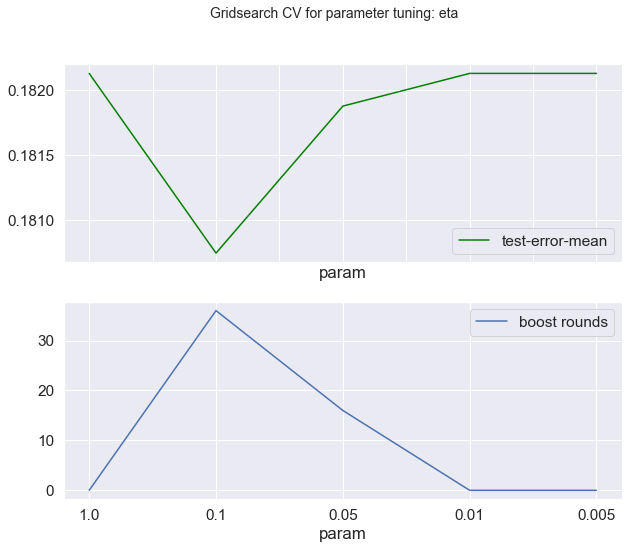

   param  test-error-mean  boost rounds
0    1.0         0.182125           0.0
1    0.1         0.180750          36.0
2   0.05         0.181875          16.0
3   0.01         0.182125           0.0
4  0.005         0.182125           0.0
Wall time: 7.72 s


In [317]:
# perform GridSearch on testing 5 values for eta
param_test5 = [1, .1, .05, .01, .005]

# timing
%time gridsearch_best_param(param_test5, 'eta', "CV with eta={}", convert_to_str=True, timed=True)

eta = 0.1 has lowest test-error-mean but highest boost rounds. 36 iterations is not very large. Therefore, we can consider 0.1 as the optimal.

In [320]:
# update best parameter
params['eta'] = 0.1

### Results

In [321]:
# tuned hyperparameters values
params

# compared with default values:
# 'max_depth': 6,
# 'min_child_weight': 1,
# 'eta': .3,
# 'subsample': 1,
# 'colsample_bytree': 1,
# 'gamma': 0,
# 'alpha': 0,
# 'lambda': 1,

{'max_depth': 3,
 'min_child_weight': 3,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'gamma': 7,
 'alpha': 0.01,
 'lambda': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [322]:
# feed in parameters to find optimal num_boost_round
xgb1 = xgb.train(
    params,
    DTrain,
    num_boost_round=1000,
    evals=[(DTest, "Test")],
    early_stopping_rounds=20
)

print("Lowest logloss: {:.2f} with {} rounds".format(xgb1.best_score, xgb1.best_iteration+1))

[0]	Test-logloss:0.64924
Will train until Test-logloss hasn't improved in 20 rounds.
[1]	Test-logloss:0.61336
[2]	Test-logloss:0.58391
[3]	Test-logloss:0.55854
[4]	Test-logloss:0.53786
[5]	Test-logloss:0.52027
[6]	Test-logloss:0.50639
[7]	Test-logloss:0.49338
[8]	Test-logloss:0.48263
[9]	Test-logloss:0.47338
[10]	Test-logloss:0.46543
[11]	Test-logloss:0.45892
[12]	Test-logloss:0.45304
[13]	Test-logloss:0.44795
[14]	Test-logloss:0.44354
[15]	Test-logloss:0.43994
[16]	Test-logloss:0.43661
[17]	Test-logloss:0.43397
[18]	Test-logloss:0.43173
[19]	Test-logloss:0.42979
[20]	Test-logloss:0.42773
[21]	Test-logloss:0.42627
[22]	Test-logloss:0.42457
[23]	Test-logloss:0.42326
[24]	Test-logloss:0.42226
[25]	Test-logloss:0.42119
[26]	Test-logloss:0.42029
[27]	Test-logloss:0.41935
[28]	Test-logloss:0.41852
[29]	Test-logloss:0.41789
[30]	Test-logloss:0.41735
[31]	Test-logloss:0.41684
[32]	Test-logloss:0.41619
[33]	Test-logloss:0.41552
[34]	Test-logloss:0.41522
[35]	Test-logloss:0.41485
[36]	Test-logl

In [323]:
# remove the early_stopping_rounds since we've got the exact optimal num_boost_round
num_boost_round = xgb1.best_iteration + 1
optimal_model = xgb.train(
    params,
    DTrain,
    num_boost_round=num_boost_round,
    evals=[(DTest, "Test")]
)

[0]	Test-logloss:0.64924
[1]	Test-logloss:0.61336
[2]	Test-logloss:0.58391
[3]	Test-logloss:0.55854
[4]	Test-logloss:0.53786
[5]	Test-logloss:0.52027
[6]	Test-logloss:0.50639
[7]	Test-logloss:0.49338
[8]	Test-logloss:0.48263
[9]	Test-logloss:0.47338
[10]	Test-logloss:0.46543
[11]	Test-logloss:0.45892
[12]	Test-logloss:0.45304
[13]	Test-logloss:0.44795
[14]	Test-logloss:0.44354
[15]	Test-logloss:0.43994
[16]	Test-logloss:0.43661
[17]	Test-logloss:0.43397
[18]	Test-logloss:0.43173
[19]	Test-logloss:0.42979
[20]	Test-logloss:0.42773
[21]	Test-logloss:0.42627
[22]	Test-logloss:0.42457
[23]	Test-logloss:0.42326
[24]	Test-logloss:0.42226
[25]	Test-logloss:0.42119
[26]	Test-logloss:0.42029
[27]	Test-logloss:0.41935
[28]	Test-logloss:0.41852
[29]	Test-logloss:0.41789
[30]	Test-logloss:0.41735
[31]	Test-logloss:0.41684
[32]	Test-logloss:0.41619
[33]	Test-logloss:0.41552
[34]	Test-logloss:0.41522
[35]	Test-logloss:0.41485
[36]	Test-logloss:0.41454
[37]	Test-logloss:0.41388
[38]	Test-logloss:0.41

In [326]:
# save model
optimal_model.save_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')

### Evaluation

In [ ]:
# load model
# loaded_model = xgb.Booster()
# loaded_model.load_model(path + 'CreditCardDefault_model_LogisticRegression_XGBoost.model')
# result = loaded_model.predict(DTest)

In [338]:
predictions_ = [int(round(value)) for value in optimal_model.predict(DTest)]

In [339]:
# evaluation - scores
print('accuracy score:', accuracy_score(y_true = ytest, y_pred = predictions_))
print('f1 score:', f1_score(y_true = ytest, y_pred = predictions_))
print('ROC AUC:', roc_auc_score(y_true = ytest, y_score = predictions_))

accuracy score: 0.8336666666666667
f1 score: 0.47528916929547843
ROC AUC: 0.6590811253471409


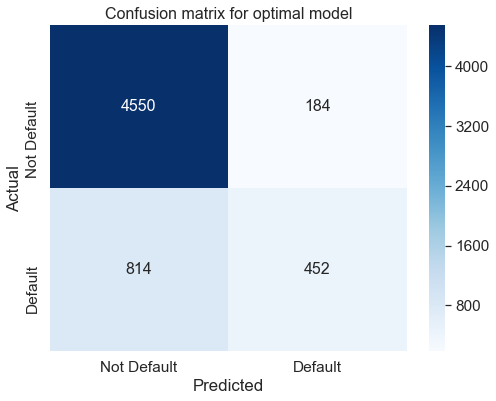

In [327]:
# evaluation - confusion matrix
optimal_cm = pd.DataFrame(confusion_matrix(ytest, predictions_), 
                       columns=['Not Default', 'Default'], index = ['Not Default', 'Default'])
optimal_cm.index.name = 'Actual'
optimal_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4) # label size
sns.heatmap(optimal_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16}) # integer format, font size 16
plt.title('Confusion matrix for optimal model', fontsize=16)
plt.show()

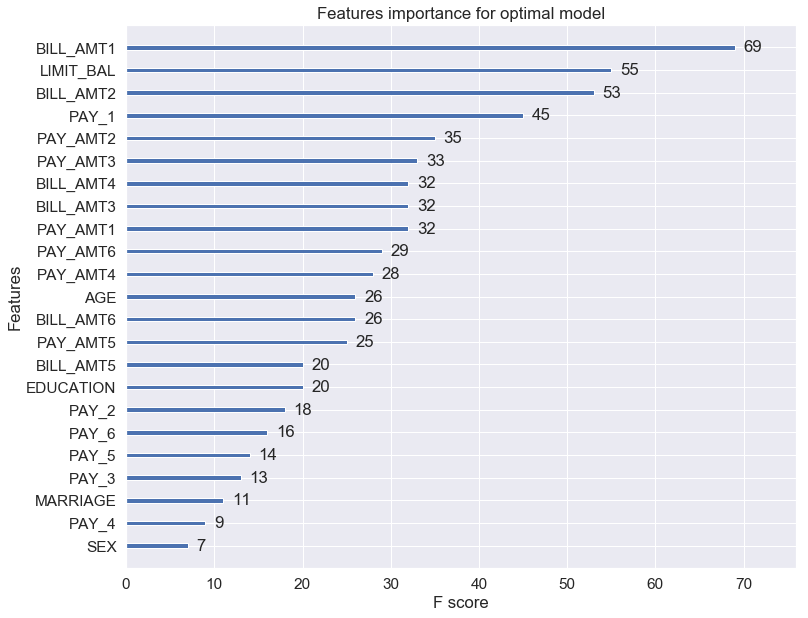

In [328]:
# features importance
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(optimal_model, importance_type='weight', ax=ax)
plt.title('Features importance for optimal model')
plt.show()

Summary of the statistics of the optimal model:
1. **Accuracy score**: 0.834
2. **f1 score**: 0.475
3. **ROC AUC**: 0.659
4. **False Positive**: 184 cases, **False Negative**: 814 cases.
5. Top 3 important features: BILL_AMT1, LIMIT_BAL, BILL_AMT2; least 3 importance features: MARRIAGE, PAY_4, SEX.
<br>

Compared to the statistics of the baseline model:
1. **Accuracy score**: 0.828
2. **f1 score**: 0.465
3. **ROC AUC**: 0.655
4. **False Positive**: 218 cases, **False Negative**: 816 cases.
5. Top 3 important features: BILL_AMT1, AGE, LIMIT_BAL; least 3 importance features: PAY_3, MARRIAGE, PAY_2.
<br>

We achieved a very tiny improvement.

In [ ]:
# Experiment with scikit-learn API

# xgb0_ = xgb.XGBClassifier(**params, n_estimators=1000)

# predictions_ = [int(round(value)) for value in xgb0.predict(Xtest)]

# param_test1_ = {
#  'max_depth':range(3,6,2),
#  'min_child_weight':range(1,4,2)
# }

# def gridsearch_best_params_(estimator, params_set):
#     model = GridSearchCV(estimator=estimator, param_grid=params_set, scoring=['roc_auc', 'f1', 'neg_log_loss'], cv=5, refit='neg_log_loss')
#     model.fit(Xtrain, ytrain, early_stopping_rounds=20)
#     gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# gridsearch_best_params_(xgb0_, param_test1_)